In [10]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.linear_model import LinearRegression

from utils.plot_utils import regression_plot_with_uncertainty
from utils.Prediction_bands import(split_conformal_bands,
                                   weighted_conformal_prediction
                                   
)
from concurrent.futures import ThreadPoolExecutor

from scipy.stats import multivariate_normal, norm

# SETTING 2: CHANGEPOINTS
# SETTING 3: Distribution drift
Interpolating $\beta^{(1)} = (2, 1, 0, 0)$ to $\beta^{N} = (0, 0, 2, 1)$

In [7]:
setting = 2

np.random.seed(12345)
N = 2000
alpha = 0.1
methods = ['CP+LS', 'nexCP+LS', 'nexCP+WLS']
ntrial = 200
train_lag = 100

rho = rho_LS = 0.99

X = np.random.normal(size = (ntrial, N, 4))
noise = np.random.normal(size = (ntrial, N))
Y = np.zeros((ntrial, N))



if setting == 2: 
    changepoints = np.r_[500, 1500]    
    num_changepoints = 2
    beta = np.array([[2, 1, 0, 0], [0, -2, -1, 0], [0, 0, 2, 1]])
    for i in np.arange(1 + num_changepoints):
        if i == 0:
            idx_min = 0
        else:
            idx_min = changepoints[i-1]

        if (i == num_changepoints):
            idx_max = N
        else:
            idx_max = changepoints[i]
            
        Y[:, idx_min:idx_max] = X[:, idx_min:idx_max].dot(beta[i]) + noise[:, idx_min:idx_max]
        
if setting == 3:

    beta_start = np.array([2,1,0,0])
    beta_end = np.array([0,0,2,1])
    beta = beta_start + np.outer(np.arange(N)/(N-1),beta_end-beta_start)

    for i in np.arange(N):
        Y[:, i] = X[:, i].dot(beta[i]) + noise[:, i]

    


#SETTING 3: CHANGEPOINT

In [8]:
# np.random.seed(12345)
# N = 2000

# beta_start = np.array([2,1,0,0])
# beta_end = np.array([0,0,2,1])
# beta = beta_start + np.outer(np.arange(N)/(N-1),beta_end-beta_start)

# ntrial = 200
# train_lag = 100

# rho = rho_LS = 0.99

# X = np.random.normal(size = (ntrial, N, 4))
# noise = np.random.normal(size = (ntrial, N))

# Y = np.zeros((ntrial, N))

# for i in np.arange(N):
#     Y[:, i] = X[:, i].dot(beta[i]) + noise[:, i]

# alpha = 0.1
# methods = ['CP+LS', 'nexCP+LS', 'nexCP+WLS']


In [9]:
beta[1999]

IndexError: index 1999 is out of bounds for axis 0 with size 3

ValueError: x and y must have same first dimension, but have shapes (2000,) and (3,)

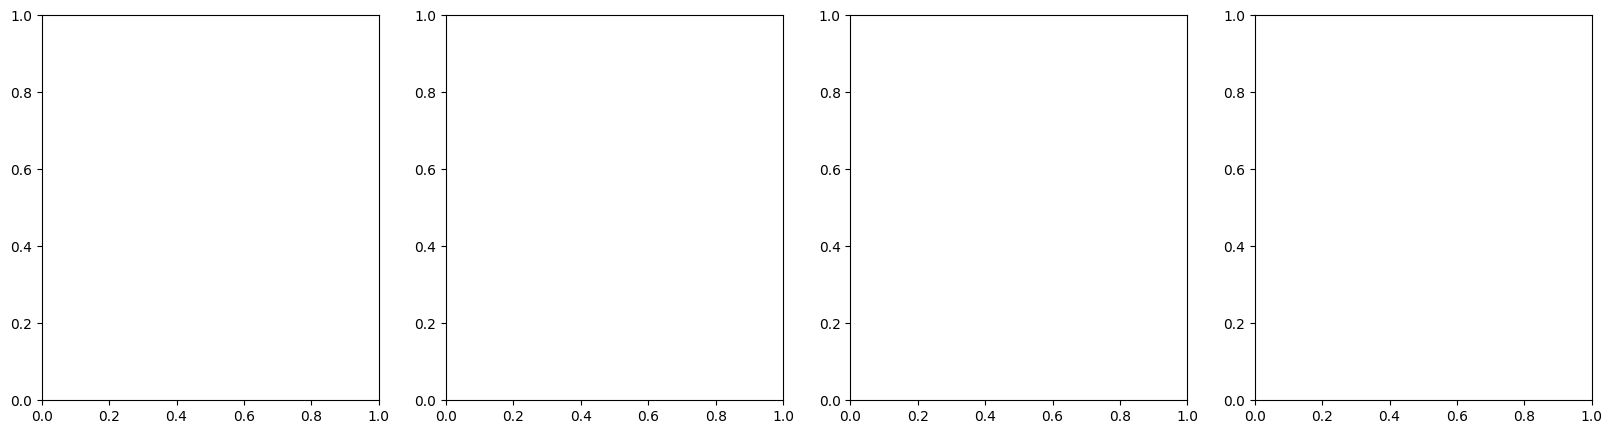

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for beta_col in range(4):
    ax[beta_col].plot(np.arange(N), beta[:, beta_col])
    ax[beta_col].set_title(r"$\beta_{}$".format(beta_col + 1))
    ax[beta_col].set_xlabel("Time")
    if beta_col == 0:
        ax[beta_col].set_ylabel(r"$\beta$") 
plt.tight_layout()
plt.show()
        

In [18]:
def run_trial(itrial):
    for pred_idx in np.arange(train_lag, N):
        # we predict the point at pred_idx (n+1) starting at pred_idx=train_lag (101-th datapoint)

        for method_idx, method in enumerate(methods):
            # calibration weights for non-exchangeable conformal prediction (nexCP)
            if method in ['nexCP+LS', 'nexCP+WLS']:
                # weights at 1, ..., n (notice: in Python arrays this becomes 0, ..., n-1)
                weights = rho**(np.arange(pred_idx,0,-1))
                # weight n+1 should always be 1
                weights = np.r_[weights,1]
        
            elif method == "gaussian":
                h = 0.84
                X_tilde = multivariate_normal.rvs(mean = X[itrial - 1, pred_idx], cov = np.diag(np.ones(4))*h**2)
                weights = np.exp(-0.5 * np.sum((X[itrial, :pred_idx] - X_tilde) , axis = 1) / h**2)
                weights = np.r_[weights, 1]
                
            else:
                weights = np.ones(pred_idx+1)
            
            # weights for weighted linear regression (WLS)
            if method == 'nexCP+WLS':
                # tags 1, ..., n+1
                tags = rho_LS**(np.arange(pred_idx,-1,-1))
                
            elif method == 'gaussian':
                tags = weights[:-1]
            else:
                tags = np.ones(pred_idx+1)
                
            
            # odd data points for training, even ones for calibration
            inds_odd = np.arange(1,int(np.ceil(pred_idx/2)*2-1),2) # excludes pred_idx
            inds_even = np.arange(2,int(np.floor(pred_idx/2)*2),2) # excludes pred_idx

            # train a weighted least squares regression (tags are the weights)
            predictor = LinearRegression()
            predictor.fit(X[itrial, inds_odd], Y[itrial, inds_odd], tags[inds_odd])

            mean_prediction, prediction_bands, quantile = weighted_conformal_prediction(
                predictor, # the trained weighted linear regression model
                X[itrial, inds_even], # calibration inputs
                Y[itrial, inds_even], # calibration targets
                X[itrial, pred_idx][np.newaxis, :], # test point to predict
                weights[inds_even], # calibration score weights
                alpha # target miscoverage rate
            )
            PI_split_CP[method_idx,itrial,pred_idx,:] = prediction_bands

In [19]:
PI_split_CP = np.zeros((len(methods),ntrial,N,2))
PI_split_CP[:, :, :train_lag, 0] = -np.inf
PI_split_CP[:, :, :train_lag, 1] = np.inf



with ThreadPoolExecutor(max_workers = 5) as executor:
        list(tqdm(executor.map(run_trial, np.arange(ntrial)), total=ntrial))

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [08:52<00:00,  2.66s/it]


In [20]:
coverage = np.zeros((len(methods),N - train_lag))
pi_width = np.zeros((len(methods),N - train_lag))


for method_idx, method in enumerate(methods):   
    lower_bound = PI_split_CP[method_idx, :, train_lag:, 0]
    upper_bound = PI_split_CP[method_idx, :, train_lag:, 1]
    
    coverage[method_idx] = np.mean((lower_bound <= Y[:, train_lag:]) & (upper_bound >= Y[:, train_lag:]), axis=0)
    pi_width[method_idx] = np.mean(upper_bound - lower_bound, axis=0)


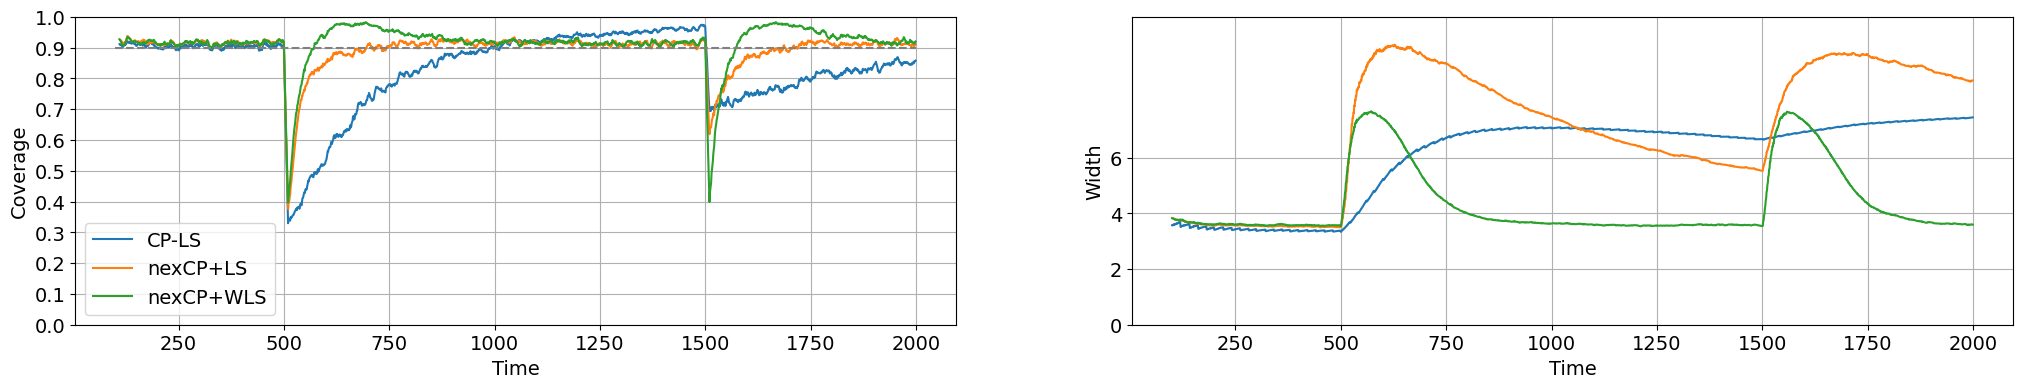

In [27]:
plt.rcParams.update({'font.size': 14})

window = 10 # will display a rolling average

def rolling_avg(x,window):
    return np.convolve(x, np.ones(window)/window)[(window-1):-window]
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,4))

for method_idx, method in enumerate(methods):
    ax[0].plot(np.arange(train_lag+window,N), rolling_avg(coverage[method_idx], window))
    ax[1].plot(np.arange(train_lag, N), pi_width[method_idx])

ax[0].hlines(1-alpha, xmin=train_lag, xmax=N, linestyles='--', colors='gray')
ax[0].legend(['CP-LS','nexCP+LS','nexCP+WLS'])

ax[0].set_ylabel('Coverage')
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax[0].set_xlabel('Time')
ax[0].grid(True)

ax[1].set_ylabel('Width')
ymax = np.max([
    pi_width[method_idx].max() for method_idx in range(len(methods))
]) * 1.1
ax[1].set_ylim([0, ymax])
ax[1].set_yticks([0, 2, 4, 6])
ax[1].set_xlabel('Time')
ax[1].grid(True)


plt.show()

In [28]:
for method_idx, method in enumerate(methods):
    print(f'{method}')
    print('-'*30)
    print(f'Avg. coverage: {np.mean(coverage[method_idx]):.3f}')
    print(f'Avg. interval width: {np.mean(pi_width[method_idx]):.2f}')
    print()

CP+LS
------------------------------
Avg. coverage: 0.836
Avg. interval width: 6.05

nexCP+LS
------------------------------
Avg. coverage: 0.893
Avg. interval width: 7.10

nexCP+WLS
------------------------------
Avg. coverage: 0.914
Avg. interval width: 4.35



In [29]:
import pandas as pd
data = {'Method': methods,
    'Avg. Coverage': [np.mean(coverage[method_idx]) for method_idx in range(len(methods))],
    'Avg. Interval Width': [np.mean(pi_width[method_idx]) for method_idx in range(len(methods))]}
df = pd.DataFrame(data)

df.head()


,Method,Avg. Coverage,Avg. Interval Width
0,CP+LS,0.836439,6.048796
1,nexCP+LS,0.893082,7.098829
2,nexCP+WLS,0.913750,4.347186


In [30]:
import pyperclip
latex_table = df.to_latex(index=False, float_format="%.3f", column_format="lcc")
pyperclip.copy(latex_table)
print("LaTeX table copied to clipboard.")


LaTeX table copied to clipboard.
